# Generate Standard Data

In [1]:
Alpha_name = "Original_Input_Moving_10_Shift_5"
# path = "/home/wuwenjun/Alpha_Factor/" + alpha_name + "/result/"
path = "/home/wuwenjun/Alpha_Factor/" + Alpha_name +"/"
output_path = r'/home/wuwenjun/factor_lib/ti0/wuwenjun'

In [2]:
import time
from Research.backtest.bt import BTDaily
from Research.feature.ft import FeatureAnalysis
import Research.utils.namespace as namespace
import Research.utils.normalization as norm
from Platform.database.mysql import MysqlAPI
from Platform.utils.persistence import convert_to_standard_daily_feature_csv, convert_to_standard_daily_feature_par
from Platform.config.mysql_info import FACTOR_LIB_MYSQL_TIO
from os import walk
import pandas as pd
import numpy as np
import torch
from datetime import datetime
import torch.nn as nn
from progressbar import ProgressBar
from tqdm import tqdm
import os

In [4]:
# 生成标准数据
df = []
for i in os.listdir(path):
    df.append(pd.read_parquet(path + i + "/" + "result.par"))
df = pd.concat(df,axis=0)
display(df)
convert_to_standard_daily_feature_csv(Alpha_name, df.drop("target",axis=1), output_path)

,timestamp,symbol,target,Original_Input_Moving_10_Shift_5
0,2020-01-02 09:30:00,000001,-0.745423,0.196408
1,2020-01-02 09:30:00,000002,-1.392706,-0.019129
2,2020-01-02 09:30:00,000004,-0.585940,-0.043689
3,2020-01-02 09:30:00,000005,-0.339156,0.042810
4,2020-01-02 09:30:00,000006,-0.523171,-0.016820
...,...,...,...,...
351664,2020-06-01 09:30:00,688388,-0.684707,-0.378105
351665,2020-06-01 09:30:00,688389,0.003000,-0.228525
351666,2020-06-01 09:30:00,688396,-0.503367,-0.605308
351667,2020-06-01 09:30:00,688398,-0.214989,-0.434566


In [32]:
# # 生成标准数据
# df = pd.DataFrame()
# for f, _, i in walk(path):
#     for j in tqdm(i):
#         df = pd.concat([df,pd.read_parquet(f + "/" + j)],axis=0)
# df['timestamp'] = pd.to_datetime(df['timestamp'])
# display(df)
# # output
# convert_to_standard_daily_feature_csv(Alpha_name, df.drop("target",axis=1), output_path)

# Loop Back Test

In [39]:
import time
from Research.backtest.bt import BTDaily
from Research.feature.ft import FeatureAnalysis
import Research.utils.namespace as namespace
import Research.utils.normalization as norm
import numpy as np

config_path = r'/home/ShareFolder/lgc/Modules/Research/config/feature_bt_template'
print('Loading the configuration from ' + config_path)
configs = namespace.load_namespace(config_path)
FT = FeatureAnalysis(configs, feature_path=r"/home/wuwenjun/factor_lib")
alpha_list = list(FT.features_in_path.keys())
alpha_list = [
#     "AlphaNetV1_Shift_5_Sequence_6_0",
    "AlphaNet_8Input_Shift_1_Sequence_20_10d_ret_standscalar_2",
#     "AlphaNetV4"
]
# alpha_list = ["LSTM_AlphaNet_Original_Input_5d_return_1","AlphaNet_Original_Input_5d_return_5d_change_1",
#               "LSTM_AlphaNet_Original_Input_5d_return_2","AlphaNet_Original_Input_5d_return_5d_change_2",
#              "LSTM_AlphaNet_Original_Input_5d_return_3","AlphaNet_Original_Input_5d_return_5d_change_3",
#               "LSTM_AlphaNet_Original_Input_5d_return_4","AlphaNet_Original_Input_5d_return_5d_change_4",
#               "LSTM_AlphaNet_Original_Input_5d_return_5","AlphaNet_Original_Input_5d_return_5d_change_5"
#              ]


print(alpha_list)
start_date = '2019-01-01'
end_date = '2021-06-01'
FT.load_feature_from_file(alpha_list, start_date, end_date, universe='Investable',
                                       timedelta=None, transformer=norm.standard_scale)
FT.load_return_data()

for alpha_name in alpha_list:
    FT.get_intersection_ic(feature_name=alpha_name, truncate_fold=None, method='spearman',
                                     period=('1d', '3d', '5d'))
    ic_flag, trading_direction = FT.test_ic(alpha_name, verbose=False)
    df, df_all = FT.get_ic_summary_by_month(num=6)

    if trading_direction == -1:
        negative = True
    else:
        negative = False
    a = FT.get_top_return(alpha_name, negative= False, trade_type='long-only', transmission_rate=0.00025,
                            tax_rate=0.001, verbose=True,bt_price = "vwap",trade_period=6)

Loading the configuration from /home/ShareFolder/lgc/Modules/Research/config/feature_bt_template


Loading Feature...:   7%|██████▌                                                                                    | 42/584 [00:00<00:02, 227.77it/s]

['AlphaNet_8Input_Shift_1_Sequence_20_10d_ret_standscalar_2']


Calculating IC value...: 100%|█████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:00<00:00, 571.64it/s]



IC table for feature "AlphaNet_8Input_Shift_1_Sequence_20_10d_ret_standscalar_2" (mean std IR):
+-------------------+------------------+------------------+------------------+------------------+------------------+
|      period       |  IC_AlphaNet_1d  |  IC_AlphaNet_2d  |  IC_AlphaNet_3d  |  IC_AlphaNet_4d  |  IC_AlphaNet_5d  |
+===================+==================+==================+==================+==================+==================+
| 20190104-20190630 |  3.74 5.25 0.71  |  4.40 5.37 0.82  |  5.02 5.62 0.89  |  5.52 6.34 0.87  |  5.53 6.77 0.82  |
+-------------------+------------------+------------------+------------------+------------------+------------------+
| 20190701-20191231 |  3.44 5.23 0.66  |  3.42 4.66 0.73  |  3.35 4.31 0.78  |  3.81 5.13 0.74  |  4.17 4.24 0.98  |
+-------------------+------------------+------------------+------------------+------------------+------------------+
| 20200101-20200630 |  4.31 5.34 0.81  |  4.59 6.26 0.73  |  4.67 5.69 0.82  |  4.89

Getting BT result for date: 20210531...: 100%|█████████████████████████████████████████████████████████████████████| 584/584 [00:05<00:00, 108.35it/s]



AlphaNet_8Input_Shift_1_Sequence_20_10d_ret_standscalar_2 back-test result for long-only mode:

Back test summary: "long-only" mode
+-------------------+-------------+----------+-----------+------------+----------+-------------+-------------------------+-------------------+------------+
|      period       |  stock_num  |  return  |  ret_std  |  ret_year  |  sharpe  |  win_ratio  |      max_dd|period      |  max_dd_day|date  |  turnover  |
+===================+=============+==========+===========+============+==========+=============+=========================+===================+============+
| 20190102-20190630 |     211     |   6.03   |   6.39    |   12.71    |   1.98   |    61.54    | 3.73(20190109-20190131) |  1.43(20190429)   |   14.41    |
+-------------------+-------------+----------+-----------+------------+----------+-------------+-------------------------+-------------------+------------+
| 20190701-20191231 |     214     |   1.49   |   4.19    |    2.87    |   0.71   |    5

In [40]:
a[1].to_csv("/home/wuwenjun/Desktop/V3.csv")

In [1]:
import time
from Research.backtest.bt import BTDaily
from Research.feature.ft import FeatureAnalysis
import Research.utils.namespace as namespace
import Research.utils.normalization as norm
import numpy as np
import pandas as pd
pd.set_option('expand_frame_repr', False)
config_path = r'/home/ShareFolder/lgc/Modules/Research/config/feature_bt_template'
print('Loading the configuration from ' + config_path)
configs = namespace.load_namespace(config_path)
FT = FeatureAnalysis(configs, feature_path=r"/home/wuwenjun/factor_lib")
alpha_list = list(FT.features_in_path.keys())[-10:]

# alpha_list = ["Original_Input_Shift_1_Sequence_10","Original_Input_Ts_Standard_Shift_1_Sequence_10","Original_Input_TsStand_Concated_Shift_1_Sequence_10"]

print(alpha_list)
start_date = '2019-01-01'
end_date = '2021-06-01'
FT.load_feature_from_file(alpha_list, start_date, end_date, universe='Investable',
                                       timedelta=None, transformer=norm.standard_scale)
FT.load_return_data()

writing_path = r'/home/wuwenjun/Desktop/return.txt'
f = open (writing_path,'w')
print("\n",file=f)
f.close()
for alpha_name in alpha_list:
    FT.get_intersection_ic(feature_name=alpha_name, truncate_fold=None, method='spearman',
                                     period=('1d', '3d', '5d'))
    ic_flag, trading_direction = FT.test_ic(alpha_name, verbose=False)
    df, df_all = FT.get_ic_summary_by_month(num=6)
    
    if trading_direction == -1:
        negative = True
    else:
        negative = False
    f = open (writing_path,'a')
    print("*"*100,end="\n"*3,file=f)
    print(alpha_name,end = "\n"*3,file=f)
    print(df,end="\n"*3,file = f)
    a = FT.get_top_return(alpha_name, negative= False, trade_type='long-only', transmission_rate=0.00025,
                            tax_rate=0.001, verbose=True,bt_price = "vwap",trade_period=6)
    print(a[1],end = "\n"*3+"*"*100 ,file = f)
    f.close()

Loading the configuration from /home/ShareFolder/lgc/Modules/Research/config/feature_bt_template


Loading Feature...:   2%|██                                                                                       | 132/5840 [00:00<00:06, 822.34it/s]

['AlphaNetV1_Shift_10_Sequence_3_0', 'AlphaNetV1_Shift_10_Sequence_3_1', 'AlphaNetV1_Shift_10_Sequence_3_2', 'AlphaNetV1_Shift_10_Sequence_3_3', 'AlphaNetV1_Shift_10_Sequence_3_4', 'AlphaNetV1_Shift_10_Sequence_3_5', 'AlphaNetV1_Shift_10_Sequence_3_6', 'AlphaNetV1_Shift_10_Sequence_3_7', 'AlphaNetV1_Shift_10_Sequence_3_8', 'AlphaNetV1_Shift_10_Sequence_3_9']


Loading Feature...:  51%|████████████████████████████████████████████▎                                          | 2974/5840 [00:02<00:02, 1256.29it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Calculating IC value...: 100%|█████████████████████████████████████████████████████████████████████████████████████| 584/584 [00:01<00:00, 473.37it/s]



IC table for feature "AlphaNetV1_Shift_10_Sequence_3_0" (mean std IR):
+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|      period       |  IC_AlphaNetV1_1d  |  IC_AlphaNetV1_2d  |  IC_AlphaNetV1_3d  |  IC_AlphaNetV1_4d  |  IC_AlphaNetV1_5d  |
+===================+====================+====================+====================+====================+====================+
| 20190102-20190630 |   3.07 4.05 0.76   |   3.78 4.75 0.79   |   3.54 5.53 0.64   |   4.09 5.31 0.77   |   4.06 4.56 0.89   |
+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| 20190701-20191231 |   2.67 3.82 0.70   |   3.29 3.30 1.00   |   4.40 2.75 1.60   |   5.44 3.84 1.42   |   4.72 4.74 0.99   |
+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| 20200101-20200630 |   4.31 3.11 1.39 

Calculating IC value...:   9%|███████▎                                                                              | 50/584 [00:00<00:02, 196.37it/s]


AlphaNetV1_Shift_10_Sequence_3_0 back-test result for long-only mode:

Back test summary: "long-only" mode
+-------------------+-------------+----------+-----------+------------+----------+-------------+-------------------------+-------------------+------------+
|      period       |  stock_num  |  return  |  ret_std  |  ret_year  |  sharpe  |  win_ratio  |      max_dd|period      |  max_dd_day|date  |  turnover  |
+===================+=============+==========+===========+============+==========+=============+=========================+===================+============+
| 20190102-20190630 |     210     |   0.47   |   5.52    |    0.96    |   0.18   |    52.99    | 4.01(20190109-20190411) |  1.20(20190429)   |    8.16    |
+-------------------+-------------+----------+-----------+------------+----------+-------------+-------------------------+-------------------+------------+
| 20190701-20191231 |     212     |   2.04   |   4.40    |    3.93    |   0.94   |    52.00    | 2.73(20190701-2

Calculating IC value...: 100%|█████████████████████████████████████████████████████████████████████████████████████| 584/584 [00:01<00:00, 576.65it/s]



IC table for feature "AlphaNetV1_Shift_10_Sequence_3_1" (mean std IR):
+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|      period       |  IC_AlphaNetV1_1d  |  IC_AlphaNetV1_2d  |  IC_AlphaNetV1_3d  |  IC_AlphaNetV1_4d  |  IC_AlphaNetV1_5d  |
+===================+====================+====================+====================+====================+====================+
| 20190103-20190630 |   3.08 5.00 0.61   |   3.56 6.18 0.58   |   4.14 6.07 0.68   |   4.02 4.89 0.82   |   4.76 6.20 0.77   |
+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| 20190701-20191231 |   1.02 4.22 0.24   |   3.47 4.64 0.75   |   4.66 5.11 0.91   |   4.61 4.76 0.97   |   3.89 4.38 0.89   |
+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| 20200101-20200630 |   2.32 4.57 0.51 

Calculating IC value...:  15%|█████████████▎                                                                        | 90/584 [00:00<00:01, 423.46it/s]


AlphaNetV1_Shift_10_Sequence_3_1 back-test result for long-only mode:

Back test summary: "long-only" mode
+-------------------+-------------+----------+-----------+------------+----------+-------------+-------------------------+-------------------+------------+
|      period       |  stock_num  |  return  |  ret_std  |  ret_year  |  sharpe  |  win_ratio  |      max_dd|period      |  max_dd_day|date  |  turnover  |
+===================+=============+==========+===========+============+==========+=============+=========================+===================+============+
| 20190102-20190630 |     210     |   2.23   |   5.85    |    4.61    |   0.82   |    58.97    | 3.05(20190110-20190131) |  0.96(20190131)   |    8.20    |
+-------------------+-------------+----------+-----------+------------+----------+-------------+-------------------------+-------------------+------------+
| 20190701-20191231 |     212     |   2.26   |   4.59    |    4.38    |   0.98   |    55.20    | 2.82(20191028-2

Calculating IC value...: 100%|█████████████████████████████████████████████████████████████████████████████████████| 584/584 [00:01<00:00, 522.57it/s]



IC table for feature "AlphaNetV1_Shift_10_Sequence_3_2" (mean std IR):
+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|      period       |  IC_AlphaNetV1_1d  |  IC_AlphaNetV1_2d  |  IC_AlphaNetV1_3d  |  IC_AlphaNetV1_4d  |  IC_AlphaNetV1_5d  |
+===================+====================+====================+====================+====================+====================+
| 20190104-20190630 |   2.44 7.29 0.33   |   3.46 6.53 0.53   |   3.86 5.54 0.70   |   4.15 6.57 0.63   |   4.59 6.95 0.66   |
+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| 20190701-20191231 |   4.32 4.62 0.94   |   5.34 5.78 0.92   |   4.44 5.90 0.75   |   4.29 6.30 0.68   |   5.00 5.61 0.89   |
+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| 20200101-20200630 |   4.87 5.54 0.88 

Calculating IC value...:  10%|████████▏                                                                             | 56/584 [00:00<00:01, 316.39it/s]


AlphaNetV1_Shift_10_Sequence_3_2 back-test result for long-only mode:

Back test summary: "long-only" mode
+-------------------+-------------+----------+-----------+------------+----------+-------------+-------------------------+-------------------+------------+
|      period       |  stock_num  |  return  |  ret_std  |  ret_year  |  sharpe  |  win_ratio  |      max_dd|period      |  max_dd_day|date  |  turnover  |
+===================+=============+==========+===========+============+==========+=============+=========================+===================+============+
| 20190102-20190630 |     210     |   7.30   |   5.38    |   15.48    |   2.84   |    59.83    | 2.50(20190109-20190131) |  0.85(20190308)   |    8.30    |
+-------------------+-------------+----------+-----------+------------+----------+-------------+-------------------------+-------------------+------------+
| 20190701-20191231 |     210     |   2.23   |   4.74    |    4.31    |   0.94   |    55.20    | 3.43(20191023-2

Calculating IC value...: 100%|█████████████████████████████████████████████████████████████████████████████████████| 584/584 [00:01<00:00, 514.36it/s]



IC table for feature "AlphaNetV1_Shift_10_Sequence_3_3" (mean std IR):
+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|      period       |  IC_AlphaNetV1_1d  |  IC_AlphaNetV1_2d  |  IC_AlphaNetV1_3d  |  IC_AlphaNetV1_4d  |  IC_AlphaNetV1_5d  |
+===================+====================+====================+====================+====================+====================+
| 20190107-20190630 |   3.85 4.00 0.96   |   4.60 4.79 0.96   |   5.33 6.36 0.84   |   5.25 7.78 0.67   |   6.36 7.39 0.86   |
+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| 20190701-20191231 |   2.86 4.55 0.63   |   2.71 5.04 0.54   |   2.59 5.02 0.52   |   3.70 4.91 0.75   |   5.08 4.99 1.02   |
+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| 20200101-20200630 |   2.69 7.09 0.38 

Calculating IC value...:   9%|███████▉                                                                              | 54/584 [00:00<00:01, 288.89it/s]


AlphaNetV1_Shift_10_Sequence_3_3 back-test result for long-only mode:

Back test summary: "long-only" mode
+-------------------+-------------+----------+-----------+------------+----------+-------------+-------------------------+-------------------+------------+
|      period       |  stock_num  |  return  |  ret_std  |  ret_year  |  sharpe  |  win_ratio  |      max_dd|period      |  max_dd_day|date  |  turnover  |
+===================+=============+==========+===========+============+==========+=============+=========================+===================+============+
| 20190102-20190630 |     210     |   5.29   |   5.94    |   11.11    |   1.88   |    58.97    | 2.57(20190109-20190201) |  1.05(20190308)   |    8.22    |
+-------------------+-------------+----------+-----------+------------+----------+-------------+-------------------------+-------------------+------------+
| 20190701-20191231 |     210     |   1.11   |   4.54    |    2.14    |   0.49   |    50.40    | 3.85(20191009-2

Calculating IC value...: 100%|█████████████████████████████████████████████████████████████████████████████████████| 584/584 [00:00<00:00, 735.77it/s]



IC table for feature "AlphaNetV1_Shift_10_Sequence_3_4" (mean std IR):
+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|      period       |  IC_AlphaNetV1_1d  |  IC_AlphaNetV1_2d  |  IC_AlphaNetV1_3d  |  IC_AlphaNetV1_4d  |  IC_AlphaNetV1_5d  |
+===================+====================+====================+====================+====================+====================+
| 20190108-20190630 |   3.30 5.97 0.55   |   4.03 6.63 0.61   |   3.77 6.83 0.55   |   5.38 6.87 0.78   |   6.01 6.41 0.94   |
+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| 20190701-20191231 |   0.04 4.48 0.01   |   1.42 3.86 0.37   |   2.63 4.70 0.56   |   3.90 5.19 0.75   |   3.59 6.23 0.58   |
+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| 20200101-20200630 |   4.55 2.60 1.75 

Calculating IC value...:  12%|██████████▍                                                                           | 71/584 [00:00<00:01, 426.94it/s]


AlphaNetV1_Shift_10_Sequence_3_4 back-test result for long-only mode:

Back test summary: "long-only" mode
+-------------------+-------------+----------+-----------+------------+----------+-------------+--------------------------+-------------------+------------+
|      period       |  stock_num  |  return  |  ret_std  |  ret_year  |  sharpe  |  win_ratio  |      max_dd|period       |  max_dd_day|date  |  turnover  |
+===================+=============+==========+===========+============+==========+=============+==========================+===================+============+
| 20190102-20190630 |     210     |   1.23   |   5.64    |    2.52    |   0.47   |    52.14    | 3.15(20190306-20190506)  |  1.15(20190314)   |    8.10    |
+-------------------+-------------+----------+-----------+------------+----------+-------------+--------------------------+-------------------+------------+
| 20190701-20191231 |     212     |   2.34   |   4.93    |    4.53    |   0.95   |    52.80    | 4.41(20190

Calculating IC value...: 100%|█████████████████████████████████████████████████████████████████████████████████████| 584/584 [00:01<00:00, 547.18it/s]



IC table for feature "AlphaNetV1_Shift_10_Sequence_3_5" (mean std IR):
+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|      period       |  IC_AlphaNetV1_1d  |  IC_AlphaNetV1_2d  |  IC_AlphaNetV1_3d  |  IC_AlphaNetV1_4d  |  IC_AlphaNetV1_5d  |
+===================+====================+====================+====================+====================+====================+
| 20190109-20190630 |   2.70 6.04 0.45   |   3.02 5.96 0.51   |   4.65 6.87 0.68   |   5.35 6.62 0.81   |   5.99 6.23 0.96   |
+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| 20190701-20191231 |   2.51 4.67 0.54   |   4.06 4.65 0.87   |   5.51 5.19 1.06   |   4.89 4.86 1.01   |   5.56 4.66 1.19   |
+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| 20200101-20200630 |   2.33 4.91 0.47 

Calculating IC value...:  11%|█████████▊                                                                            | 67/584 [00:00<00:01, 358.33it/s]


AlphaNetV1_Shift_10_Sequence_3_5 back-test result for long-only mode:

Back test summary: "long-only" mode
+-------------------+-------------+----------+-----------+------------+----------+-------------+--------------------------+-------------------+------------+
|      period       |  stock_num  |  return  |  ret_std  |  ret_year  |  sharpe  |  win_ratio  |      max_dd|period       |  max_dd_day|date  |  turnover  |
+===================+=============+==========+===========+============+==========+=============+==========================+===================+============+
| 20190102-20190630 |     211     |   2.77   |   5.80    |    5.73    |   1.02   |    53.85    | 3.32(20190108-20190131)  |  1.01(20190308)   |    8.13    |
+-------------------+-------------+----------+-----------+------------+----------+-------------+--------------------------+-------------------+------------+
| 20190701-20191231 |     212     |   1.20   |   4.31    |    2.30    |   0.56   |    50.40    | 1.90(20190

Calculating IC value...: 100%|█████████████████████████████████████████████████████████████████████████████████████| 584/584 [00:01<00:00, 517.12it/s]



IC table for feature "AlphaNetV1_Shift_10_Sequence_3_6" (mean std IR):
+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|      period       |  IC_AlphaNetV1_1d  |  IC_AlphaNetV1_2d  |  IC_AlphaNetV1_3d  |  IC_AlphaNetV1_4d  |  IC_AlphaNetV1_5d  |
+===================+====================+====================+====================+====================+====================+
| 20190110-20190630 |   2.41 3.37 0.71   |   4.77 6.71 0.71   |   4.87 6.74 0.72   |   5.55 7.04 0.79   |   5.50 7.37 0.75   |
+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| 20190701-20191231 |   3.01 3.98 0.76   |   4.72 4.16 1.13   |   4.16 4.67 0.89   |   4.23 4.84 0.87   |   5.22 4.89 1.07   |
+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| 20200101-20200630 |   3.38 6.48 0.52 

Calculating IC value...:  12%|██████████                                                                            | 68/584 [00:00<00:01, 377.39it/s]


AlphaNetV1_Shift_10_Sequence_3_6 back-test result for long-only mode:

Back test summary: "long-only" mode
+-------------------+-------------+----------+-----------+------------+----------+-------------+-------------------------+-------------------+------------+
|      period       |  stock_num  |  return  |  ret_std  |  ret_year  |  sharpe  |  win_ratio  |      max_dd|period      |  max_dd_day|date  |  turnover  |
+===================+=============+==========+===========+============+==========+=============+=========================+===================+============+
| 20190102-20190630 |     210     |  -1.02   |   5.58    |   -2.07    |  -0.40   |    54.70    | 6.29(20190109-20190507) |  1.05(20190429)   |    8.21    |
+-------------------+-------------+----------+-----------+------------+----------+-------------+-------------------------+-------------------+------------+
| 20190701-20191231 |     211     |  -2.34   |   4.30    |   -4.42    |  -1.11   |    51.20    | 3.43(20190702-2

Calculating IC value...: 100%|█████████████████████████████████████████████████████████████████████████████████████| 584/584 [00:01<00:00, 571.59it/s]



IC table for feature "AlphaNetV1_Shift_10_Sequence_3_7" (mean std IR):
+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|      period       |  IC_AlphaNetV1_1d  |  IC_AlphaNetV1_2d  |  IC_AlphaNetV1_3d  |  IC_AlphaNetV1_4d  |  IC_AlphaNetV1_5d  |
+===================+====================+====================+====================+====================+====================+
| 20190111-20190630 |   4.75 7.20 0.66   |   5.55 7.72 0.72   |   6.64 7.50 0.89   |   6.67 7.64 0.87   |   6.89 7.91 0.87   |
+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| 20190701-20191231 |   6.10 5.61 1.09   |   4.39 4.84 0.91   |   4.24 5.55 0.76   |   5.38 4.96 1.08   |   5.49 4.34 1.27   |
+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| 20200101-20200630 |   4.20 3.68 1.14 

Calculating IC value...:  10%|████████▏                                                                             | 56/584 [00:00<00:01, 317.37it/s]


AlphaNetV1_Shift_10_Sequence_3_7 back-test result for long-only mode:

Back test summary: "long-only" mode
+-------------------+-------------+----------+-----------+------------+----------+-------------+-------------------------+-------------------+------------+
|      period       |  stock_num  |  return  |  ret_std  |  ret_year  |  sharpe  |  win_ratio  |      max_dd|period      |  max_dd_day|date  |  turnover  |
+===================+=============+==========+===========+============+==========+=============+=========================+===================+============+
| 20190102-20190630 |     210     |   0.77   |   6.17    |    1.58    |   0.27   |    57.26    | 3.80(20190110-20190201) |  1.09(20190429)   |    8.24    |
+-------------------+-------------+----------+-----------+------------+----------+-------------+-------------------------+-------------------+------------+
| 20190701-20191231 |     211     |  -0.67   |   4.67    |   -1.27    |  -0.29   |    57.60    | 3.91(20190919-2

Calculating IC value...: 100%|█████████████████████████████████████████████████████████████████████████████████████| 584/584 [00:01<00:00, 431.84it/s]



IC table for feature "AlphaNetV1_Shift_10_Sequence_3_8" (mean std IR):
+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|      period       |  IC_AlphaNetV1_1d  |  IC_AlphaNetV1_2d  |  IC_AlphaNetV1_3d  |  IC_AlphaNetV1_4d  |  IC_AlphaNetV1_5d  |
+===================+====================+====================+====================+====================+====================+
| 20190114-20190630 |   3.33 6.19 0.54   |   5.84 7.01 0.83   |   5.44 6.79 0.80   |   5.58 6.58 0.85   |   6.20 6.71 0.92   |
+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| 20190701-20191231 |   0.87 3.74 0.23   |   2.83 4.62 0.61   |   3.96 4.58 0.87   |   4.53 4.43 1.02   |   4.88 4.27 1.14   |
+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| 20200101-20200630 |   3.07 4.42 0.70 

Calculating IC value...:  10%|████████▍                                                                             | 57/584 [00:00<00:01, 320.64it/s]


AlphaNetV1_Shift_10_Sequence_3_8 back-test result for long-only mode:

Back test summary: "long-only" mode
+-------------------+-------------+----------+-----------+------------+----------+-------------+-------------------------+-------------------+------------+
|      period       |  stock_num  |  return  |  ret_std  |  ret_year  |  sharpe  |  win_ratio  |      max_dd|period      |  max_dd_day|date  |  turnover  |
+===================+=============+==========+===========+============+==========+=============+=========================+===================+============+
| 20190102-20190630 |     209     |   0.70   |   5.83    |    1.44    |   0.26   |    58.97    | 4.41(20190114-20190410) |  1.29(20190429)   |    7.48    |
+-------------------+-------------+----------+-----------+------------+----------+-------------+-------------------------+-------------------+------------+
| 20190701-20191231 |     210     |   0.10   |   4.32    |    0.18    |   0.04   |    54.40    | 3.17(20190702-2

Calculating IC value...: 100%|█████████████████████████████████████████████████████████████████████████████████████| 584/584 [00:01<00:00, 566.27it/s]



IC table for feature "AlphaNetV1_Shift_10_Sequence_3_9" (mean std IR):
+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|      period       |  IC_AlphaNetV1_1d  |  IC_AlphaNetV1_2d  |  IC_AlphaNetV1_3d  |  IC_AlphaNetV1_4d  |  IC_AlphaNetV1_5d  |
+===================+====================+====================+====================+====================+====================+
| 20190115-20190630 |   3.74 6.18 0.61   |   4.21 6.61 0.64   |   5.12 6.43 0.80   |   5.60 6.10 0.92   |   6.17 5.76 1.07   |
+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| 20190701-20191231 |   2.82 5.25 0.54   |   4.26 4.65 0.92   |   4.37 3.57 1.22   |   4.82 2.94 1.64   |   5.18 3.64 1.42   |
+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| 20200101-20200630 |   3.17 3.38 0.94 

Getting BT result for date: 20210531...: 100%|█████████████████████████████████████████████████████████████████████| 584/584 [00:05<00:00, 105.70it/s]



AlphaNetV1_Shift_10_Sequence_3_9 back-test result for long-only mode:

Back test summary: "long-only" mode
+-------------------+-------------+----------+-----------+------------+----------+-------------+-------------------------+-------------------+------------+
|      period       |  stock_num  |  return  |  ret_std  |  ret_year  |  sharpe  |  win_ratio  |      max_dd|period      |  max_dd_day|date  |  turnover  |
+===================+=============+==========+===========+============+==========+=============+=========================+===================+============+
| 20190102-20190630 |     209     |   2.39   |   5.55    |    4.95    |   0.93   |    54.70    | 3.30(20190114-20190408) |  1.08(20190429)   |    7.50    |
+-------------------+-------------+----------+-----------+------------+----------+-------------+-------------------------+-------------------+------------+
| 20190701-20191231 |     213     |   3.01   |   4.40    |    5.83    |   1.36   |    54.40    | 2.29(20191028-2

In [9]:
alpha_list = []
for i in range(1,11):
    alpha_list.append("LSTM_AlphaNet_Original_Input_10d_return_" + str(i))
    alpha_list.append("AlphaNet_Original_Input_10d_return_10d_change_" + str(i))
alpha_list

['LSTM_AlphaNet_Original_Input_10d_return_1',
 'AlphaNet_Original_Input_10d_return_10d_change_1',
 'LSTM_AlphaNet_Original_Input_10d_return_2',
 'AlphaNet_Original_Input_10d_return_10d_change_2',
 'LSTM_AlphaNet_Original_Input_10d_return_3',
 'AlphaNet_Original_Input_10d_return_10d_change_3',
 'LSTM_AlphaNet_Original_Input_10d_return_4',
 'AlphaNet_Original_Input_10d_return_10d_change_4',
 'LSTM_AlphaNet_Original_Input_10d_return_5',
 'AlphaNet_Original_Input_10d_return_10d_change_5',
 'LSTM_AlphaNet_Original_Input_10d_return_6',
 'AlphaNet_Original_Input_10d_return_10d_change_6',
 'LSTM_AlphaNet_Original_Input_10d_return_7',
 'AlphaNet_Original_Input_10d_return_10d_change_7',
 'LSTM_AlphaNet_Original_Input_10d_return_8',
 'AlphaNet_Original_Input_10d_return_10d_change_8',
 'LSTM_AlphaNet_Original_Input_10d_return_9',
 'AlphaNet_Original_Input_10d_return_10d_change_9',
 'LSTM_AlphaNet_Original_Input_10d_return_10',
 'AlphaNet_Original_Input_10d_return_10d_change_10']

In [3]:
FT.

{Timestamp('2019-01-11 09:30:00'):         AlphaNetV4_LSTM_2    5m_ret   15m_ret   30m_ret   60m_ret  120m_ret  \
 ticker                                                                        
 600863           4.834759  0.004219  0.004219  0.008439  0.004219  0.008439   
 300563           4.202657 -0.000383 -0.001533 -0.003448 -0.022222 -0.026820   
 603555           4.016805  0.001647  0.001647  0.004942  0.008237  0.006590   
 600136           3.660336  0.001199  0.003597  0.003597 -0.007194 -0.005995   
 300168           3.406607  0.001721  0.000861  0.001721 -0.012048 -0.010327   
 ...                   ...       ...       ...       ...       ...       ...   
 600766          -4.179094 -0.009009 -0.010135 -0.010135  0.010135  0.011261   
 600604          -4.355297 -0.002774 -0.006935 -0.001387  0.012483  0.011096   
 300141          -4.867316 -0.019355 -0.030108 -0.055914 -0.058065 -0.081720   
 300545          -5.551759 -0.020192 -0.032692 -0.039904 -0.045192 -0.040865   
 60061

In [26]:
print(a[1])

                   stock_num    return    ret_std   ret_year    sharpe  win_ratio             max_dd|period max_dd_day|date   turnover
period                                                                                                                                
20200102-20200630        228 -2.063980   6.642814  -4.204965 -0.686112  48.275862   5.26(20200114-20200430)  1.40(20200428)  16.876996
20200701-20201231        238  3.300551   8.640747   6.407954  0.729155  52.000000   6.64(20201027-20201230)  2.82(20200910)  15.181028
20210101-20210531        259  5.154742  15.823399  13.301223  0.881989  48.958333  10.09(20210104-20210210)  3.21(20210107)  14.872591


In [5]:
print(df)

                       IC_LSTM_1d      IC_LSTM_2d      IC_LSTM_3d  \
period                                                              
20200102-20200331  0.20 5.58 0.04  3.53 5.65 0.62  2.83 7.02 0.40   
20200401-20200630  5.10 4.85 1.05  5.39 3.74 1.44  5.52 3.59 1.53   
20200701-20200930  1.91 7.26 0.26  5.55 6.05 0.92  6.33 7.71 0.82   
20201001-20201231  6.93 8.87 0.78  5.49 7.34 0.75  6.34 7.35 0.86   
20210101-20210331  2.04 6.16 0.33  5.88 8.49 0.69  9.07 7.81 1.16   
20210401-20210630  5.41 4.65 1.16  4.64 4.58 1.01  3.52 5.45 0.65   

                       IC_LSTM_4d      IC_LSTM_5d  
period                                             
20200102-20200331  4.82 4.68 1.03  5.03 3.74 1.34  
20200401-20200630  5.96 3.50 1.70  6.87 3.75 1.83  
20200701-20200930  7.85 7.54 1.04  8.15 7.67 1.06  
20201001-20201231  4.86 7.79 0.62  4.91 8.81 0.56  
20210101-20210331  7.98 7.99 1.00  9.48 7.87 1.21  
20210401-20210630  4.97 6.60 0.75  5.51 8.19 0.67  


In [20]:
import time
from Research.backtest.bt import BTDaily
from Research.feature.ft import FeatureAnalysis
import Research.utils.namespace as namespace
import Research.utils.normalization as norm
import numpy as np

config_path = r'/home/ShareFolder/lgc/Modules/Research/config/feature_bt_template'
print('Loading the configuration from ' + config_path)
configs = namespace.load_namespace(config_path)
FT = FeatureAnalysis(configs, feature_path=r"/home/wuwenjun/factor_lib")
alpha_list = list(FT.features_in_path.keys())

alpha_list = [
                "AlphaNetV3",
#              "AlphaNetV1_Original_Input_1208",
#               "Attention_8Input_Shift_1_Sequence_20_10d_ret_standscalar"
#                 "AlphaNetV1_Shift_5_Sequence_6"
             ]
start_date = '2019-01-01'
end_date = '2021-01-01'


FT.load_feature_from_file(alpha_list, start_date, end_date, universe='Investable',
                                   timedelta=None, transformer=norm.standard_scale)
FT.load_return_data()

for alpha_name in alpha_list:
#     FT.get_intersection_ic(feature_name=alpha_name, truncate_fold=None, method='spearman',
#                            period=('1d', '3d', '5d'))
#     ic_flag, trading_direction = FT.test_ic(alpha_name, verbose=False)
#     df, df_all = FT.get_ic_summary_by_month(num=6)
#     if trading_direction == -1:
#         negative = True
#     else:
#         negative = False

    result, holdings = FT.get_group_returns(alpha_name, negative=True,group_num=5)

    # result为输入特征文件回测的结果，数据类型为DataFrame， holdings为分组的每日持仓，数据类型为字段，取第一组的持仓，查询holdings[0]即可，返回值为以日期为key的字典。
    print(result.head())
    print(holdings[0])

Loading the configuration from /home/ShareFolder/lgc/Modules/Research/config/feature_bt_template


Getting BT result for date: 20201231...: 100%|██████████████████████████████████████████████████████████████████████| 487/487 [00:10<00:00, 47.40it/s]


           alpha_group0  alpha_group1  alpha_group2  alpha_group3  \
timestamp                                                           
20190102       1.007224      1.004971      1.006179      1.005831   
20190103       1.008548      1.007132      1.008944      1.007902   
20190104       1.013368      1.009269      1.009610      1.009641   
20190107       1.017546      1.011603      1.008883      1.011428   
20190108       1.020353      1.014332      1.012605      1.012145   

           alpha_group4  net_group0  net_group1  net_group2  net_group3  \
timestamp                                                                 
20190102       1.004558    0.996651    0.994398    0.995606    0.995259   
20190103       0.992500    0.993342    0.991928    0.993728    0.992695   
20190104       0.991792    1.021776    1.017685    1.018080    1.018079   
20190107       0.994513    1.044781    1.038756    1.036071    1.038604   
20190108       0.993483    1.044976    1.038887    1.037229    1.0

In [21]:
result

,alpha_group0,alpha_group1,alpha_group2,alpha_group3,alpha_group4,net_group0,net_group1,net_group2,net_group3,net_group4,...,turnover_group1,turnover_group2,turnover_group3,turnover_group4,stock_num_group0,stock_num_group1,stock_num_group2,stock_num_group3,stock_num_group4,benchmark_value
timestamp,,,,,,,,,,,,,,,,,,,,,
20190102,1.007224,1.004971,1.006179,1.005831,1.004558,0.996651,0.994398,0.995606,0.995259,0.993985,...,0.996619,0.996504,0.995990,0.995195,683,680,683,680,683,0.989427
20190103,1.008548,1.007132,1.008944,1.007902,0.992500,0.993342,0.991928,0.993728,0.992695,0.977447,...,0.663162,0.661021,0.636462,0.398484,686,687,682,695,684,0.984842
20190104,1.013368,1.009269,1.009610,1.009641,0.991792,1.021776,1.017685,1.018080,1.018079,1.000058,...,0.613591,0.658444,0.604240,0.382609,688,691,686,686,686,1.008326
20190107,1.017546,1.011603,1.008883,1.011428,0.994513,1.044781,1.038756,1.036071,1.038604,1.021194,...,0.638793,0.642788,0.650390,0.413466,689,692,688,688,681,1.026870
20190108,1.020353,1.014332,1.012605,1.012145,0.993483,1.044976,1.038887,1.037229,1.036670,1.017510,...,0.666545,0.655542,0.660609,0.415952,687,696,692,683,684,1.024230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20201225,1.345663,1.236732,1.144309,1.029957,0.603910,2.017327,1.874465,1.738706,1.555044,0.900719,...,0.619527,0.582774,0.594170,0.376786,750,749,754,750,747,1.503432
20201228,1.340093,1.227749,1.134548,1.022669,0.604214,1.998047,1.850694,1.714455,1.535615,0.896291,...,0.604453,0.619283,0.603891,0.347819,752,750,753,749,746,1.495287
20201229,1.346884,1.243745,1.147628,1.030743,0.597170,1.993892,1.861578,1.721967,1.536764,0.879437,...,0.609979,0.615251,0.614670,0.391644,753,751,751,750,749,1.484600


<AxesSubplot:xlabel='timestamp'>

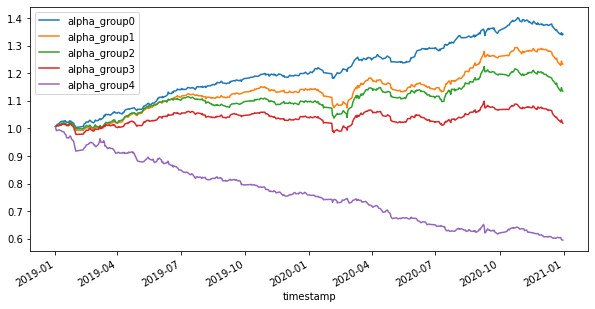

In [22]:
import pandas as pd
result.index = result.index.map(lambda x : pd.to_datetime(str(x)))
result.iloc[:,:5].plot(figsize=(10,5))

<AxesSubplot:xlabel='timestamp'>

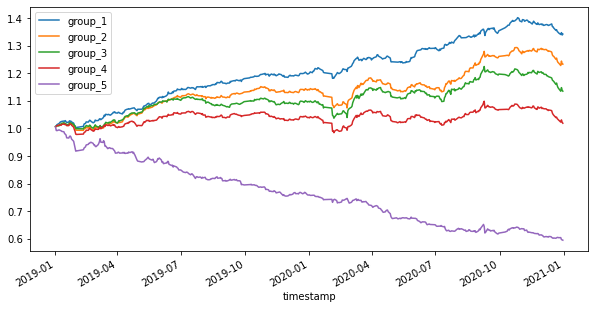

In [27]:
b.plot(figsize=(10,5))

In [100]:
pd.DataFrame([1+(i/len(result))*0.3 for i in range(len(result))])

,0
0,1.000000
1,1.000616
2,1.001232
3,1.001848
4,1.002464
...,...
482,1.296920
483,1.297536
484,1.298152
485,1.298768


In [122]:
# result2["alpha_group0_weight"] = pd.DataFrame([1+(i/len(result))*0.3 for i in range(len(result))])
a_list = []
for i , item in enumerate(result["alpha_group0"]):
    a_list.append(item * 1+(i/len(result2))*1)
a_list

[1.0085571123535675,
 1.015777576867728,
 1.0244195746888705,
 1.031101720199421,
 1.0370902717389927,
 1.0421259314138984,
 1.0442422873625163,
 1.0485408432115864,
 1.051225391766206,
 1.0526513511376487,
 1.0571721476755696,
 1.057251670428169,
 1.0559543480450568,
 1.0592107384761595,
 1.0671194022964268,
 1.0676129204155145,
 1.0707044359153126,
 1.0701158069019325,
 1.0672955035697154,
 1.063813177232887,
 1.0631683017480478,
 1.054030966169592,
 1.0568951015315768,
 1.0629992523934613,
 1.0734750104729474,
 1.0780844119907131,
 1.0818634248628947,
 1.0889881304980407,
 1.0894504295623078,
 1.0950843094809768,
 1.1019693644377944,
 1.1047388335586463,
 1.1030602762899557,
 1.0999375905580862,
 1.1024383167720375,
 1.107684834450383,
 1.1181883770500163,
 1.119532507463583,
 1.1230442863215806,
 1.1261046171910767,
 1.131833840619735,
 1.1331115044997029,
 1.1341539262786315,
 1.1429409316804526,
 1.1480969577566913,
 1.1605047226799996,
 1.1615398857814996,
 1.1709219728863496,
 

<AxesSubplot:xlabel='timestamp'>

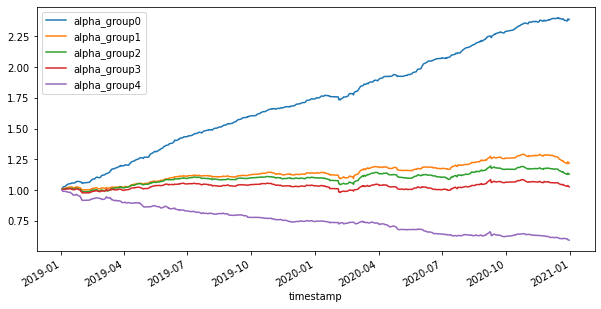

In [123]:
result2["alpha_group0"] = a_list
result2.iloc[:,:5].plot(figsize=(10,5))

<AxesSubplot:xlabel='timestamp'>

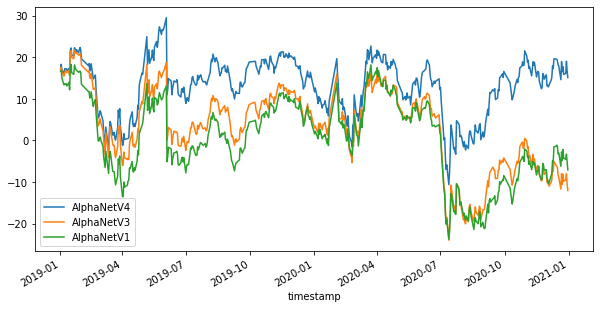

In [42]:
a = pd.read_parquet("/home/wuwenjun/Desktop/return.par")
a.plot(figsize=(10,5))

<AxesSubplot:xlabel='timestamp'>

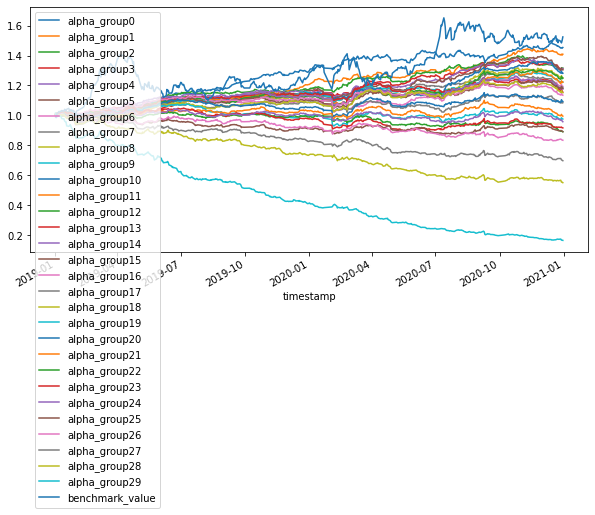

In [61]:
result2 = pd.concat([result.iloc[:,:30],result.loc[:,"benchmark_value"]],axis=1)
result2.plot(figsize=(10,5))

<AxesSubplot:xlabel='timestamp'>

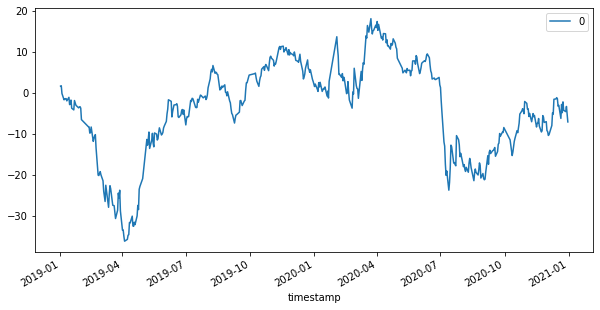

In [62]:
pd.DataFrame(result2["alpha_group0"]*100 - result2["benchmark_value"]*100).plot(figsize=(10,5))

In [64]:
result6 = pd.DataFrame(result2["alpha_group0"]*100 - result2["benchmark_value"]*100)
result6.columns = ["AlphaNetV1"]

In [63]:
a.drop(["AlphaNetV1"],axis=1,inplace=True)

In [65]:
a = pd.concat([a,result6],axis=1)
a

,AlphaNetV4,AlphaNetV3,AlphaNetV1
timestamp,,,
2019-01-02,2.325754,2.027026,1.676530
2019-01-03,3.294081,2.590418,1.778625
2019-01-04,1.946208,1.422749,-0.124055
2019-01-07,1.148229,0.438294,-1.665007
2019-01-08,2.229936,1.184912,-1.482299
...,...,...,...
2020-12-25,15.880720,-9.795254,-4.216331
2020-12-28,16.109259,-9.529508,-4.547112
2020-12-29,19.025010,-8.028795,-3.285427


In [83]:
a.iloc[60:100,:] = a.iloc[60:100,:] + 5

In [86]:
a.to_parquet("/home/wuwenjun/Desktop/return.par")

In [57]:
df.rename(columns = {"symbol":"ticker","timestamp":"date"},inplace=True)
df = df[['date','ticker',alpha_name]]
df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y%m%d').astype(int)
df.set_index("date",inplace=True)
df

,ticker,AlphaNetV1_Original_Input_1208
date,,
20190102,1,0.001571
20190103,1,0.060317
20190104,1,0.174096
20190107,1,0.301100
20190108,1,0.143749
...,...,...
20210623,601399,-0.001553
20210624,601399,-0.029387
20210625,601399,0.019083


In [58]:
df['ticker'] = df['ticker'].apply(lambda x : str(x).zfill(6))
data_frame = df.copy()
data_frame

,ticker,AlphaNetV1_Original_Input_1208
date,,
20190102,000001,0.001571
20190103,000001,0.060317
20190104,000001,0.174096
20190107,000001,0.301100
20190108,000001,0.143749
...,...,...
20210623,601399,-0.001553
20210624,601399,-0.029387
20210625,601399,0.019083


In [61]:
data_frame

,ticker,AlphaNetV1_Original_Input_1208
date,,
20190102,000001,0.001571
20190103,000001,0.060317
20190104,000001,0.174096
20190107,000001,0.301100
20190108,000001,0.143749
...,...,...
20210623,601399,-0.001553
20210624,601399,-0.029387
20210625,601399,0.019083


In [22]:
# time_df = pd.DataFrame(df['date'].drop_duplicates())
# time_df['year'] = time_df['date'].apply(lambda x : str(x.year))
# time_df['month'] = time_df['date'].apply(lambda x : str(x.month).zfill(2))
# time_df['day'] = time_df['date'].apply(lambda x : str(x.day).zfill(2))
# time_df['date_convert'] = time_df["year"] + time_df['month'] + time_df['day']
# time_df = time_df[["date","date_convert"]]
# df = pd.merge(df,time_df,left_on = "date" , right_on = "date",how="left")
# df['date'] = df['date_convert']
# df.drop('date_convert',axis=1,inplace=True)
# df.set_index("date",inplace=True)
# df

,date,date_convert
0,2019-01-02 09:30:00,20190102
1,2019-01-03 09:30:00,20190103
2,2019-01-04 09:30:00,20190104
3,2019-01-07 09:30:00,20190107
4,2019-01-08 09:30:00,20190108
...,...,...
112,2021-06-23 09:30:00,20210623
113,2021-06-24 09:30:00,20210624
114,2021-06-25 09:30:00,20210625
115,2021-06-28 09:30:00,20210628


In [71]:
config_path = r'/home/ShareFolder/lgc/Modules/Platform/config/combo_bt_template'
print('Loading the configuration from ' + config_path)
bt_price = "close"

start_date = '2019-01-02'
end_date = '2021-06-30'
configs = namespace.load_namespace(config_path)
configs.trading_type = 'long-only'
configs.data_format = 'dataframe'
configs.ti = 0
configs.trade_period = 0
configs.stock_percentage = False
configs.stock_num = 100
configs.transmission_rate = 0.0
configs.benchmark = "ZZ500"
configs.bt_price = bt_price
configs.universe = "Investable"
#configs.score_sorted = False
configs.keep_pos_percentile = 0.0

# df = standard_res.reset_index()

# df.columns = ['date', 'ticker', 'model']
# #df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y%m%d').astype(int)
# df.set_index('date', inplace=True)
#####################################

bt = BTDaily(configs, start_date=start_date, end_date= end_date)

bt.feed_data(data_frame)
bt.run()
start =int(datetime.strptime(start_date, '%Y-%m-%d').date().strftime('%Y%m%d'))
end = int(datetime.strptime(end_date, '%Y-%m-%d').date().strftime('%Y%m%d'))
df, df_final = bt.evaluate(evalRange=((start, end),))

  0%|                                                                                                                         | 0/605 [00:00<?, ?it/s]

Loading the configuration from /home/ShareFolder/lgc/Modules/Platform/config/combo_bt_template


Getting BT result for date: 20210630...: 100%|██████████████████████████████████████████████████████████████████████| 605/605 [00:45<00:00, 13.20it/s]



Back test summary: "short-only" mode
+-------------------+-------------+----------+-----------+------------+----------+-------------+--------------------------+-------------------+------------+
|      period       |  stock_num  |  return  |  ret_std  |  ret_year  |  sharpe  |  win_ratio  |      max_dd|period       |  max_dd_day|date  |  turnover  |
+===================+=============+==========+===========+============+==========+=============+==========================+===================+============+
| 20190102-20210630 |     222     |  39.77   |   13.88   |   14.27    |   0.99   |    54.30    | 13.56(20190404-20191112) |  4.89(20200203)   |   39.67    |
+-------------------+-------------+----------+-----------+------------+----------+-------------+--------------------------+-------------------+------------+
